In [1]:
import json
from re import S
from keras import optimizers
from keras.optimizer_v1 import Adam, Optimizer
from numpy.core.fromnumeric import ndim
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import string
import matplotlib.pyplot as plt

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from tensorflow.python.keras.layers.pooling import GlobalMaxPool1D, GlobalMaxPooling1D, MaxPooling1D

In [2]:
df = pd.read_csv('raw_data.csv')
df['Sentimen'] = pd.to_numeric(df['Sentimen'], errors='coerce').fillna(0)
df.fillna(0)
#df.Sentimen.astype('int')
df.ulasan_.astype('string')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nama      2096 non-null   object 
 1   ulasan_   2079 non-null   object 
 2   tanggal   2079 non-null   object 
 3   Sentimen  2096 non-null   float64
dtypes: float64(1), object(3)
memory usage: 65.6+ KB


,nama,ulasan_,tanggal,Sentimen
0,Ransi Lintin,Aplikasinya bagus,2022-02-20 00:07:51,1.0
1,HAHAHAHA HAHAHA,Ok mantap,2022-02-20 00:48:59,1.0
2,Yundi Hartono,Mantap semoga semakin maju,2022-02-20 01:33:10,1.0
3,Nunu Nugraha,Bisa hemat biaya tf mantap ini sih rekomen ban...,2022-02-20 04:15:04,1.0
4,bahtiar hamzah,Mantap,2022-02-20 04:22:43,1.0
5,muaddi aja,Selama ini bagus transaksi lancar,2022-02-20 05:04:37,1.0
6,JANUARDI .,Transaksi cepat tanpa biaya antar bank,2022-02-20 05:05:24,1.0
7,Mudi Pangestu,Aplikasi ya bagus sangat membantu Makasi flip ...,2022-02-20 05:06:48,1.0
8,TRISNANDA HILMI,Alhamdulillah. Banyak ngebantu dg aplikasi ini,2022-02-20 05:23:13,1.0
9,Padry Alfath,aplikasi terbaik yang sangat membantu pekerjaa...,2022-02-20 05:43:46,1.0


In [4]:
#punctuation removal
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["ulasan_"] = df['ulasan_'].apply(lambda text: remove_punctuation(str(text)))
#df.to_csv("flip_preprocessing_punctuationremoval.csv", sep=";", index = 0)

df.head()

puncts = [',', '.', '"', ':', '(', ')', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '<', '%', '=', '#', '*', '+', '//', '\\', '@', '~', '`', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, '')
    return x

df['ulasan_'] = df['ulasan_'].apply(lambda text: remove_punctuation(text))

df.head()

,nama,ulasan_,tanggal,Sentimen
0,Ransi Lintin,Aplikasinya bagus,2022-02-20 00:07:51,1.0
1,HAHAHAHA HAHAHA,Ok mantap,2022-02-20 00:48:59,1.0
2,Yundi Hartono,Mantap semoga semakin maju,2022-02-20 01:33:10,1.0
3,Nunu Nugraha,Bisa hemat biaya tf mantap ini sih rekomen ban...,2022-02-20 04:15:04,1.0
4,bahtiar hamzah,Mantap,2022-02-20 04:22:43,1.0


In [5]:
#Case Folding
df['ulasan_'] = df['ulasan_'].str.lower()

df.head()

,nama,ulasan_,tanggal,Sentimen
0,Ransi Lintin,aplikasinya bagus,2022-02-20 00:07:51,1.0
1,HAHAHAHA HAHAHA,ok mantap,2022-02-20 00:48:59,1.0
2,Yundi Hartono,mantap semoga semakin maju,2022-02-20 01:33:10,1.0
3,Nunu Nugraha,bisa hemat biaya tf mantap ini sih rekomen ban...,2022-02-20 04:15:04,1.0
4,bahtiar hamzah,mantap,2022-02-20 04:22:43,1.0


In [6]:
#stopwords removal
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()

stopwords = ['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'sehingga', 'oleh']

def remove_stopwords(text_remove) :
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text_remove).split() if word not in stopwords])

df['ulasan_'] = df['ulasan_'].apply(lambda text: remove_stopwords(text))

df.head()

,nama,ulasan_,tanggal,Sentimen
0,Ransi Lintin,aplikasinya bagus,2022-02-20 00:07:51,1.0
1,HAHAHAHA HAHAHA,ok mantap,2022-02-20 00:48:59,1.0
2,Yundi Hartono,mantap semoga semakin maju,2022-02-20 01:33:10,1.0
3,Nunu Nugraha,bisa hemat biaya tf mantap ini sih rekomen ban...,2022-02-20 04:15:04,1.0
4,bahtiar hamzah,mantap,2022-02-20 04:22:43,1.0


In [7]:
#Stemming
factory = StemmerFactory()

stemmer = factory.create_stemmer()

def stemming(text):
    return stemmer.stem(text)

df['ulasan_'] = df['ulasan_'].apply(lambda text: stemming(text))

In [8]:
y = df['Sentimen']
y = to_categorical(y)

text = df['ulasan_'].tolist()
#y = y.tolist()

print(y)
#print(text)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [9]:
df['Sentimen'].value_counts()

1.0    1650
2.0     377
0.0      69
Name: Sentimen, dtype: int64

In [10]:
#Tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
#print('Done')
#print(tokenizer.index_word)
vocab = len(tokenizer.index_word)+1

In [11]:
x = ['possible pretty']
tokenizer.texts_to_sequences(x)

[[]]

In [12]:
encode_text = tokenizer.texts_to_sequences(text)
max_kata = 100
x = pad_sequences(encode_text, maxlen=max_kata, padding='post')
print(x)

[[  9  16   0 ...   0   0   0]
 [ 59  19   0 ...   0   0   0]
 [ 19  61  53 ...   0   0   0]
 ...
 [599 304 291 ...   0   0   0]
 [  2   3  28 ...   0   0   0]
 [  2   3 369 ...   0   0   0]]


In [13]:
#Split train and test Data
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=40, test_size= 0.3, stratify=y)

X_train = np.array([x_train])
X_test = np.array([x_test])
Y_train = np.array([y_train])
Y_test = np.array([y_test])

In [14]:
#Embedding and Add Layer

vec_size = 300
model = Sequential()
model.add(Embedding(vocab, vec_size, input_length=max_kata))
model.add(Conv1D(64, 8, activation="relu"))
#model.add(MaxPool1D(pool_size=2)
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          752700    
                                                                 
 conv1d (Conv1D)             (None, 93, 64)            153664    
                                                                 
 module_wrapper (ModuleWrapp  (None, 46, 64)           0         
 er)                                                             
                                                                 
 dropout (Dropout)           (None, 46, 64)            0         
                                                                 
 dense (Dense)               (None, 46, 32)            2080      
                                                                 
 dropout_1 (Dropout)         (None, 46, 32)            0         
                                                        

In [15]:
#CNN Compile model

adam = tf.keras.optimizers.Adam(learning_rate=0.1)

model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=[['accuracy', 'mse']])

train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

hst =model.fit(train_data, 
            epochs=20,
            batch_size= 32,
            validation_data=(valid_data))

score = model.evaluate(valid_data, verbose=1)

print('Test Score : ', score[0])
print('Test Accuracy : ', score[1])

Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 0.7240 - accuracy: 0.0327 - mse: 0.2385 - val_loss: 1.1702 - val_accuracy: 0.7870 - val_mse: 0.1420
Epoch 2/20
1/1 [==============================] - 4s 4s/step - loss: 3.3670 - accuracy: 0.7873 - mse: 0.1418 - val_loss: 3.3462 - val_accuracy: 0.7870 - val_mse: 0.1420
Epoch 3/20
1/1 [==============================] - 5s 5s/step - loss: 14.5419 - accuracy: 0.7873 - mse: 0.1418 - val_loss: 30.7619 - val_accuracy: 0.1797 - val_mse: 0.5469
Epoch 4/20
1/1 [==============================] - 4s 4s/step - loss: 79.4963 - accuracy: 0.1800 - mse: 0.5467 - val_loss: 2.0209 - val_accuracy: 0.1797 - val_mse: 0.5433
Epoch 5/20
1/1 [==============================] - 4s 4s/step - loss: 5.5495 - accuracy: 0.1800 - mse: 0.5467 - val_loss: 0.5583 - val_accuracy: 0.8267 - val_mse: 0.1278
Epoch 6/20
1/1 [==============================] - 4s 4s/step - loss: 0.7763 - accuracy: 0.7982 - mse: 0.1297 - val_loss: 0.5019 - val_accuracy: 0.7886 -

In [ ]:
model.history.history.keys()

In [25]:
hst.history

{'loss': [0.6325806379318237,
  0.49445924162864685,
  0.4476752281188965,
  0.4417840242385864,
  0.4120911955833435,
  0.40437692403793335,
  0.40177881717681885,
  0.3927532136440277,
  0.3895770013332367,
  0.38518059253692627,
  0.38262179493904114,
  0.380163311958313,
  0.3787320554256439,
  0.37841758131980896,
  0.37944456934928894,
  0.3781149089336395,
  0.37847745418548584,
  0.3802640736103058,
  0.38013580441474915,
  0.38041868805885315],
 'accuracy': [0.8343558311462402,
  0.786639392375946,
  0.7873210906982422,
  0.786639392375946,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422,
  0.7873210906982422],
 'mse': [0.10558102279901505,
  0.12571145594120026,
  0.12452387809753418,
  0.12470866739

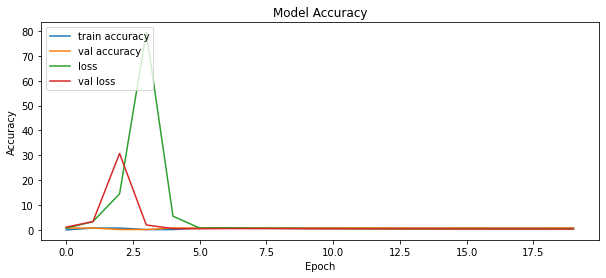

In [16]:
#loss_per_epoch = model.history.history[score[0]]
#plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

model_prediction = hst.history

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction['accuracy'], label = 'train accuracy')
ax.plot(model_prediction['val_accuracy'], label = 'val accuracy')
ax.plot(model_prediction['loss'], label = 'loss')
ax.plot(model_prediction['val_loss'], label = 'val loss')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

In [17]:
x= ['Kurang banget ini mah']
get_encode(x)
def get_encode(x):
    x = token.texts_to_sequences(x)
    x = pad_sequences(x, maxlen= 100, padding='post')
    result_raw = model.predict(x)
    result = np.argmax(result_raw)
    
    return result

#result = get_encode(x)

print(result)

NameError: name 'get_encode' is not defined

In [31]:
token=Tokenizer()

def get_encode(x):
    x = token.texts_to_sequences(x)
    x = pad_sequences(x, maxlen= 100, padding='post')
    return x

def get_predict(x):
    #model = loaded_model
    result = model.predict(x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    #result = np.argmax(result1, axis=1)
    return result


data = ['Keren aplikasinya']
encode = get_encode(data)
result = get_predict(encode)
#result = model.predict_classes(encode)
#print(result)

labels_test = [1, 0]

prediction_labels_test=[]
for p in result:
    prediction_labels_test.append(labels_test[np.argmax(p)])

print(prediction_labels_test)


[0]


In [54]:
import sklearn
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix


y_pred = model.predict(x_train)
#y_pred = model.predict(x_train)
#scoe_acc = accuracy_score(y_test, y_pred)
print("Nilai accuracy ", y_pred)
#confusion_matrix(y_train, y_pred)

Nilai accuracy  [[0.00409948 0.9347488  0.06115174]
 [0.00409948 0.9347488  0.06115174]
 [0.00409948 0.9347488  0.06115174]
 ...
 [0.00409948 0.9347488  0.06115174]
 [0.00409948 0.9347488  0.06115174]
 [0.00409948 0.9347488  0.06115174]]


In [63]:
x = ['jelek banget nih aplikasi nya']
get_encode(x)
def get_encode(x):
    x = token.texts_to_sequences(x)
    x = pad_sequences(x, maxlen= 100, padding='post')
    result_raw = model.predict(x)
    #result = np.argmax(result_raw)
    result = result_raw
    
    return result

result = get_encode(x)

print(result)

[[0.00409948 0.9347488  0.06115174]]
